# Test SALLY on WBF -> 4l data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
from sklearn.metrics import mean_squared_error

from madminer.plotting import plot_2d_morphing_basis
from madminer.ml import MLForge, EnsembleForge
from madminer.plotting import plot_fisher_information_contours_2d
from madminer.fisherinformation import FisherInformation


## Settings

In [2]:
train = False
n_estimators = 3
n_epochs = 10

## Train ensemble

In [3]:
ensemble_all = EnsembleForge(estimators=n_estimators, debug=False)

if train:
    ensemble_all.train_all(
        method='sally',
        x_filename='data/samples/x.npy',
        t_xz0_filename='data/samples/t_xz.npy',
        n_epochs=n_epochs
    )
    ensemble_all.save('data/models/ensemble_all')
    
else:
    ensemble_all.load('data/models/ensemble_all')

14:36  
14:36  ------------------------------------------------------------
14:36  |                                                          |
14:36  |  MadMiner v2018.11.06                                    |
14:36  |                                                          |
14:36  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
14:36  |                                                          |
14:36  ------------------------------------------------------------
14:36  
14:36  Found ensemble with 3 estimators and expectations None


In [4]:
ensemble_2d = EnsembleForge(estimators=n_estimators, debug=False)

if train:
    ensemble_2d.train_all(
        method='sally',
        x_filename='data/samples/x.npy',
        t_xz0_filename='data/samples/t_xz.npy',
        n_epochs=n_epochs,
        features=[[1,41] for _ in range(n_estimators)]
    )
    ensemble_2d.save('data/models/ensemble_2d')
    
else:
    ensemble_2d.load('data/models/ensemble_2d')

14:35  Found ensemble with 3 estimators and expectations None


## Score estimation

In [5]:
x = np.load('data/samples/x.npy')
t_truth = np.load('data/samples/t_xz.npy')

In [6]:
if train:
    t_hat_all, _ = ensemble_all.evaluate(
        x_filename='data/samples/x.npy',
        calculate_covariance = False
    )
    np.save('data/results/t_hat_all.npy', t_hat_all)
    
else:
    t_hat_all = np.load('data/results/t_hat_all.npy')


In [7]:
if train:
    t_hat_2d, _ = ensemble_2d.evaluate(
        x_filename='data/samples/x.npy',
        calculate_covariance = False
    )

    np.save('data/results/t_hat_2d.npy', t_hat_2d)
    
else:
    t_hat_2d = np.load('data/results/t_hat_2d.npy')

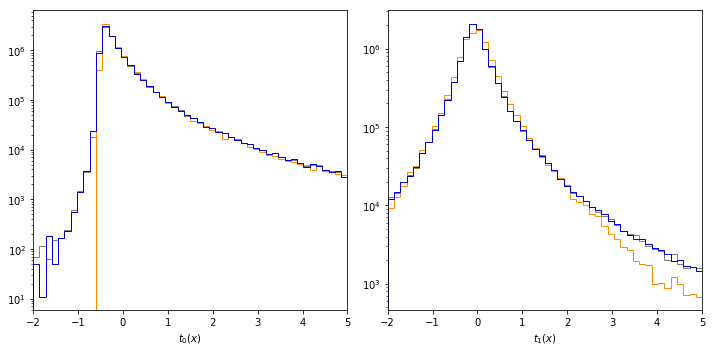

In [8]:
fig = plt.figure(figsize=(10,5))

for i in range(2):
    ax = plt.subplot(1,2,i+1)

    plt.hist(t_truth[:,i], range=(-2,5.), bins=50, histtype='step', color='0.5')
    plt.hist(t_hat_2d[:,i], range=(-2,5.), bins=50, histtype='step', color='darkorange')
    plt.hist(t_hat_all[:,i], range=(-2,5.), bins=50, histtype='step', color='mediumblue')

    plt.xlabel(r'$t_' + str(i) + '(x)$')
    plt.xlim(-2,5.)
    ax.set_yscale("log", nonposy='clip')
    
plt.tight_layout()
plt.show()


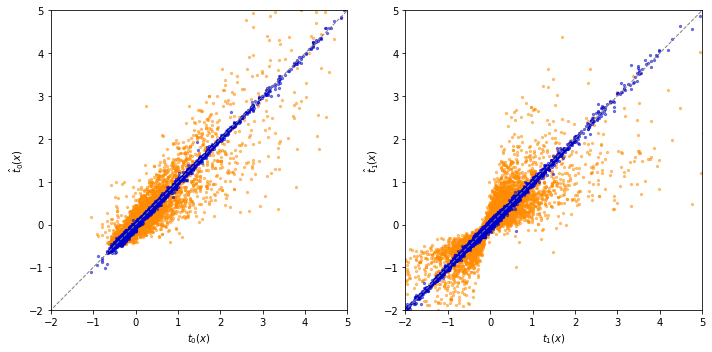

In [9]:
skip=1000

fig = plt.figure(figsize=(10,5))

for i in range(2):
    ax = plt.subplot(1,2,i+1)
    
    plt.plot([-5.,10.], [-5.,10.], c='0.5', lw=1., ls='--')

    plt.scatter(t_truth[::skip,i], t_hat_2d[::skip,i], s=5., alpha=0.5, c='darkorange')
    plt.scatter(t_truth[::skip,i], t_hat_all[::skip,i], s=5., alpha=0.5, c='mediumblue')

    plt.xlabel(r'$t_' + str(i) + '(x)$')
    plt.ylabel(r'$\hat{t}_' + str(i) + '(x)$')
    plt.xlim(-2.,5.)
    plt.ylim(-2.,5.)
    
plt.tight_layout()
plt.show()


In [10]:
np.mean(np.linalg.norm(t_truth - t_hat_all, axis=1)) / np.mean(np.linalg.norm(t_truth, axis=1))

0.0467454812073428

## Fisher information contours

In [3]:
if train:
    fisher_info_all, fisher_cov_all = ensemble_all.calculate_fisher_information(
        x='data/samples/x.npy',
        n_events=36
    )

    np.save('data/results/fisher_info_all.npy', fisher_info_all)
    np.save('data/results/fisher_cov_all.npy', fisher_cov_all)
    
else:
    fisher_info_all = np.load('data/results/fisher_info_all.npy')
    fisher_cov_all = np.load('data/results/fisher_cov_all.npy')

In [4]:
if train:
    fisher_info_2d, fisher_cov_2d = ensemble_2d.calculate_fisher_information(
        x='data/samples/x.npy',
        n_events=36
    )
    np.save('data/results/fisher_info_2d.npy', fisher_info_2d)
    np.save('data/results/fisher_cov_2d.npy', fisher_cov_2d)
    
else:
    fisher_info_2d = np.load('data/results/fisher_info_2d.npy')
    fisher_cov_2d = np.load('data/results/fisher_cov_2d.npy')

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


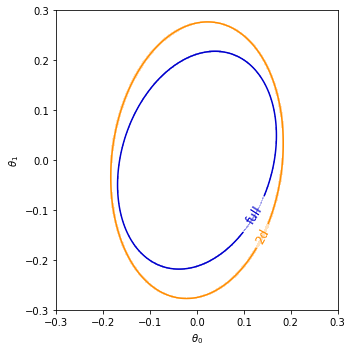

In [5]:
_ = plot_fisher_information_contours_2d(
    [fisher_info_2d, fisher_info_all],
    [fisher_cov_2d, fisher_cov_all],
    colors=['darkorange', 'mediumblue'],
    linestyles=['-', '-'],
    xrange=(-.3,.3),
    yrange=(-.3,.3),
    inline_labels=['2d', 'full']
)

In [8]:
fisher_info_all

array([[36.77757922, -6.48572436],
       [-6.48572436, 22.1619516 ]])